<a href="https://colab.research.google.com/github/Saksit-Jittasopee/AI-Workshop-2-Image-Processing/blob/main/semantic_segmentation_and_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment

In [ ]:
import os
import numpy as np
import glob
import shutil
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import OxfordIIITPet
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"device: {DEVICE}")

BATCH_SIZE = 16
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

validation_split = .2

device: cuda:0


# Download Dataset

In [ ]:
# Create directory for train and valid sets
data_dir = './oxford-pet-dataset'
for s in ['train', 'valid']:
    for t in ['img', 'mask']:
        new_dir = f'./oxford-pet-dataset/{s}_{t}'
        if not os.path.isdir(new_dir):
            os.makedirs(new_dir)
if not os.path.isdir('./saved_imgs'):
    os.makedirs('./saved_imgs')

In [ ]:
# Download dataset
OxfordIIITPet(
    root='./',
    split='trainval',
    target_types='segmentation',
    download=True)

oxford_img_dir = '/content/oxford-iiit-pet/images'
oxford_mask_dir = '/content/oxford-iiit-pet/annotations/trimaps'

100%|██████████| 792M/792M [00:30<00:00, 25.7MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.6MB/s]


In [ ]:
# Split
img_paths = glob.glob(
    os.path.join(oxford_img_dir,'*.jpg'))
dataset_size = len(img_paths)
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(img_paths)
train_paths, val_paths = img_paths[split:], img_paths[:split]

In [ ]:
# Copy files
for split_name, paths in [('train', train_paths), ('valid', val_paths)]:
    for src_img in paths:
        fn = os.path.basename(src_img)
        mask_fn = fn.replace('.jpg', '.png')
        src_mask = os.path.join(oxford_mask_dir, mask_fn)
        dst_img = os.path.join(data_dir, f'{split_name}_img', fn)
        dst_mask = os.path.join(data_dir, f'{split_name}_mask', mask_fn)
        shutil.copy(src_img, dst_img)
        shutil.copy(src_mask, dst_mask)

# Prepare Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)
        mask = mask - 1  # Make it start from 0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
# Transformation for data augmentation
train_transform = A.Compose(
    [
        # TODO: Play around with this
        # Ref: https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [ ]:
# DataSet and DataLoader

# TODO: Create dataloaders for training and validation sets
train_ds =  CustomDataset('/content/oxford-pet-dataset/train_img','/content/oxford-pet-dataset/train_mask',train_transform)
valid_ds = CustomDataset('/content/oxford-pet-dataset/valid_img','/content/oxford-pet-dataset/valid_mask',train_transform)
train_loader =  DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=16, shuffle=True)

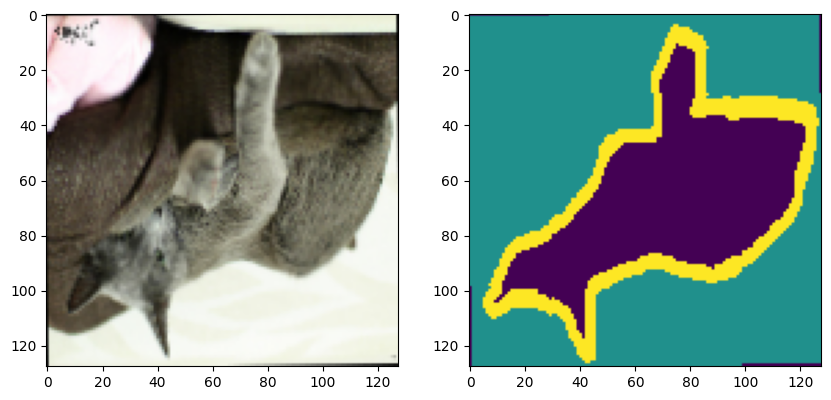

In [ ]:
# Plot an example
import numpy
img, mask = train_ds[42]
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img.numpy().transpose((1,2,0)))
axs[1].imshow(mask.numpy())
plt.show()
plt.close('all')

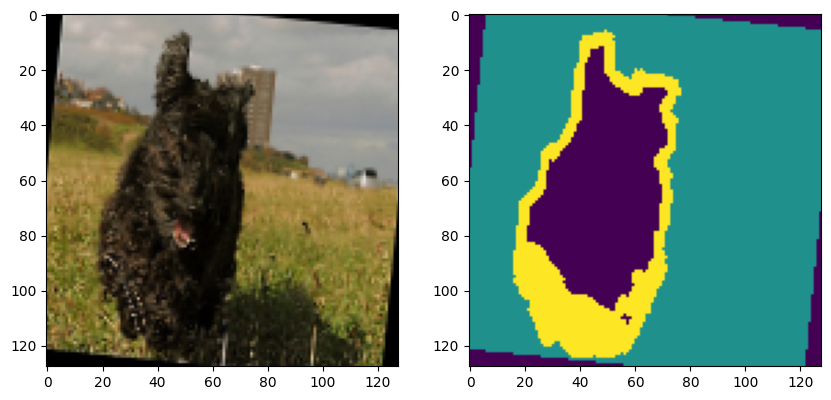

In [ ]:
# Plot an example
img, mask = valid_ds[42]
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img.numpy().transpose((1,2,0)))
axs[1].imshow(mask.numpy())
plt.show()
plt.close('all')

# Model

![u-net](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, channels=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for chs in channels:
            self.downs.append(DoubleConv(in_channels, chs))
            in_channels = chs

        # Up part of UNET
        for chs in reversed(channels):
            self.ups.append(
                nn.ConvTranspose2d(
                    chs*2, chs, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(chs*2, chs))

        self.bottleneck = DoubleConv(channels[-1], channels[-1]*2)
        self.final_conv = nn.Conv2d(channels[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
# TODO: Create a UNET model
model = UNET(in_channels=3, out_channels=3)
model = model.to(DEVICE)

# Training

In [ ]:
# One training epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    model.train()
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
# Utility functions
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

In [ ]:
# Check the performance before training
check_accuracy(val_loader, model, device=DEVICE)

Got 2754809/24215552 with acc 11.38


In [ ]:
# Training config
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

# TODO: Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/tmp/ipython-input-3684934510.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/370 [00:00<?, ?it/s]/tmp/ipython-input-3202104308.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 370/370 [01:09<00:00,  5.31it/s, loss=0.408]


=> Saving checkpoint
Got 19850061/24215552 with acc 81.97


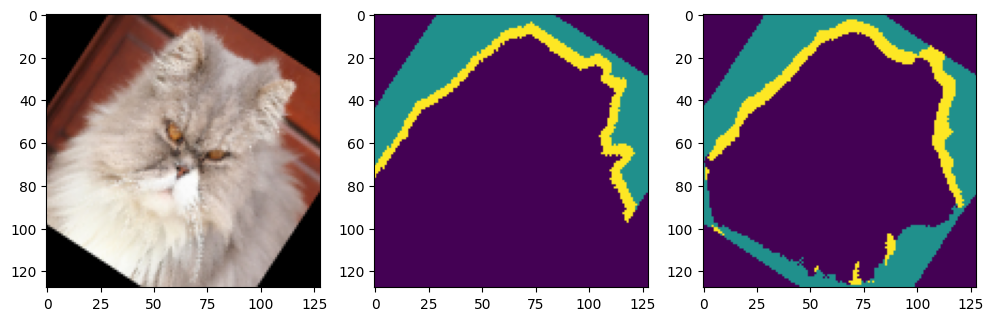

100%|██████████| 370/370 [01:08<00:00,  5.44it/s, loss=0.377]


=> Saving checkpoint
Got 20343673/24215552 with acc 84.01


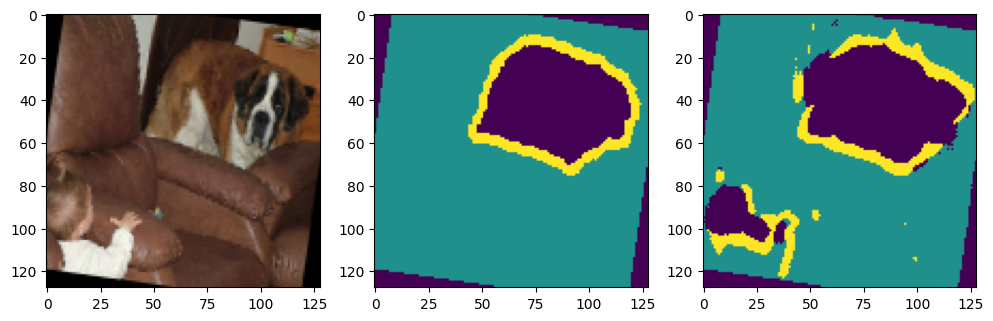

In [ ]:
# Load the pre-trained model (if any)
if os.path.isfile("my_checkpoint.pth.tar"):
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Start training
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # test on validation set
    model.eval()
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device=DEVICE)
    logits = model(imgs)
    pred_masks = torch.argmax(logits, dim=1)
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    axs[0].imshow(imgs[i].cpu().numpy().transpose(1,2,0))
    axs[1].imshow(masks[i].cpu().numpy())
    axs[2].imshow(pred_masks[i].cpu().numpy())
    plt.show()
    plt.close('all')

# Prediction

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving beagle-hound-dog.webp to beagle-hound-dog.webp


In [ ]:
# TODO: Create a UNET model
loaded_model = UNET(in_channels=3, out_channels=3)

# TODO: Load the trained model
# trained_model = torch.load('/content/my_checkpoint.pth.tar')
load_checkpoint(torch.load("my_checkpoint.pth.tar"),loaded_model)

=> Loading checkpoint


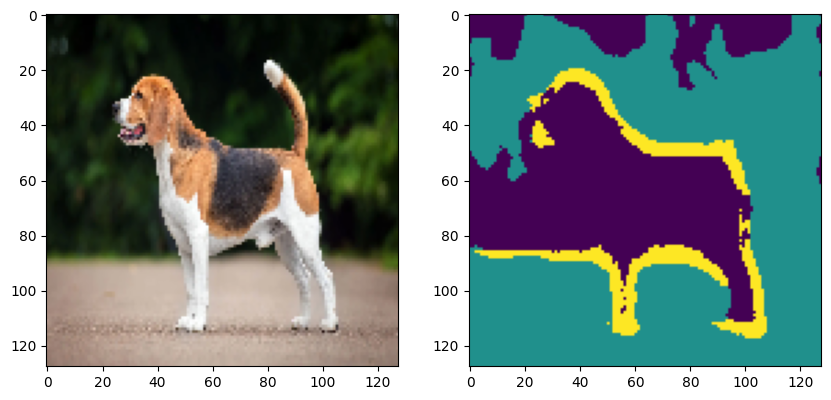

In [ ]:
for img_path in uploaded:
    # Step 1: Read an uploaded image
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)
    # Step 2: Apply transformation
    img = val_transform(image=img)['image']

    # Step 3: Add batch dimension
    img = img.unsqueeze(0)
    with torch.no_grad():
      logits = loaded_model(img)


    # Step 4: Make predictions (will get the logits)

    with torch.no_grad():
      logits = loaded_model(img)

    # Step 5: Convert the logits to predicted mask
    pred_mask = torch.argmax(logits,dim=1)

    # Plot the predicted mask
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(img[0].cpu().numpy().transpose(1,2,0))
    axs[1].imshow(pred_mask[0].cpu().numpy())
    plt.show()
    plt.close('all')

# Object Detection

We use a **pretrained Faster R-CNN** (ResNet-50 + FPN backbone) from torchvision.
The model is applied to the same Oxford-IIIT Pet images to draw bounding boxes
around detected objects, complementing the U-Net segmentation masks.

Pipeline overview:
1. Load pretrained Faster R-CNN (COCO weights)
2. Build a detection dataset from the existing pet images
3. Run inference and visualise boxes + segmentation masks side-by-side
4. (Optional) Fine-tune the detector on the pet dataset


In [ ]:
# Additional imports for object detection
import torchvision.models.detection as detection_models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import torchvision.transforms as T
import cv2
import random
from collections import defaultdict

In [ ]:
class DetectionDataset(Dataset):
    """
    Wraps the pet images for Faster R-CNN.
    Bounding boxes are derived from the trimap segmentation mask
    (foreground pixels = class 1 in the original mask).
    """
    # COCO class index for 'cat' and 'dog'; we map all pets to class 1
    NUM_CLASSES = 2  # background + pet

    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir  = mask_dir
        self.transforms = transforms
        # Only keep images that have a matching mask
        self.images = [
            f for f in os.listdir(image_dir)
            if os.path.isfile(os.path.join(mask_dir, f.replace('.jpg', '.png')))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.image_dir,  self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))

        # Load image as float tensor in [0, 1]
        img  = Image.open(img_path).convert('RGB')
        img_tensor = T.ToTensor()(img)

        # Load trimap mask: pixel values 1=foreground, 2=background, 3=border
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)
        fg   = (mask == 1).astype(np.uint8)  # isolate pet foreground

        # Derive bounding box from the foreground region (non-zero pixels)
        rows = np.any(fg, axis=1)
        cols = np.any(fg, axis=0)
        if not rows.any():  # fallback: full image box
            ymin, ymax = 0, fg.shape[0] - 1
            xmin, xmax = 0, fg.shape[1] - 1
        else:
            ymin, ymax = np.where(rows)[0][[0, -1]]
            xmin, xmax = np.where(cols)[0][[0, -1]]

        # Faster R-CNN expects boxes as [x1, y1, x2, y2]
        boxes  = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.ones(1, dtype=torch.int64)   # all pets share class 1
        area   = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(1, dtype=torch.int64)  # single object per image

        target = {
            'boxes':   boxes,
            'labels':  labels,
            'area':    area,
            'iscrowd': iscrowd,
            'image_id': torch.tensor([idx]),
        }

        if self.transforms:
            img_tensor = self.transforms(img_tensor)

        return img_tensor, target


# Collate fn: Faster R-CNN expects a list of (image, target) tuples per batch
def collate_fn(batch):
    return tuple(zip(*batch))


# Build detection loaders from the already-split directories
det_train_ds = DetectionDataset(
    '/content/oxford-pet-dataset/train_img',
    '/content/oxford-pet-dataset/train_mask'
)
det_val_ds = DetectionDataset(
    '/content/oxford-pet-dataset/valid_img',
    '/content/oxford-pet-dataset/valid_mask'
)

det_train_loader = DataLoader(
    det_train_ds, batch_size=4, shuffle=True,
    collate_fn=collate_fn, num_workers=2
)
det_val_loader = DataLoader(
    det_val_ds, batch_size=4, shuffle=False,
    collate_fn=collate_fn, num_workers=2
)
print(f'Detection train samples : {len(det_train_ds)}')
print(f'Detection val   samples : {len(det_val_ds)}')

Detection train samples : 5912
Detection val   samples : 1478


In [ ]:
def build_detection_model(num_classes=2, pretrained=True):
    """
    Load Faster R-CNN with ResNet-50 FPN backbone.
    Replace the box-prediction head to match our class count.
    """
    # Start from COCO pretrained weights (91 classes)
    det_model = detection_models.fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # Swap the classification head for our binary task (background + pet)
    in_features = det_model.roi_heads.box_predictor.cls_score.in_features
    det_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return det_model


# Instantiate and move to device
det_model = build_detection_model(num_classes=DetectionDataset.NUM_CLASSES)
det_model = det_model.to(DEVICE)
print('Faster R-CNN ready:', type(det_model).__name__)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


Faster R-CNN ready: FasterRCNN


In [ ]:
det_optimizer = torch.optim.AdamW(
    [p for p in det_model.parameters() if p.requires_grad],
    lr=1e-3, weight_decay=1e-4
)

DET_EPOCHS = 2
det_scaler = torch.cuda.amp.GradScaler()

def train_detection_epoch(loader, model, optimizer, scaler):
    model.train()
    total_loss, skipped = 0.0, 0
    loop = tqdm(loader, desc='Det train')

    for images, targets in loop:
        optimizer.zero_grad(set_to_none=True)

        try:
            # 1. Wrap data movement in the try block
            images  = [img.to(DEVICE, non_blocking=True) for img in images]
            targets = [{k: v.to(DEVICE, non_blocking=True) for k, v in t.items()} for t in targets]

            # 2. Use the updated AMP API (to silence the FutureWarnings)
            with torch.amp.autocast('cuda'):
                loss_dict = model(images, targets)
                losses    = sum(loss_dict.values())

            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += losses.item()
            loop.set_postfix(loss=f'{losses.item():.4f}', skip=skipped)

        except torch.cuda.OutOfMemoryError:
            skipped += 1
            # Clear everything to recover
            optimizer.zero_grad(set_to_none=True)
            if 'losses' in locals(): del losses
            if 'loss_dict' in locals(): del loss_dict
            del images, targets
            torch.cuda.empty_cache()
            loop.set_postfix(loss='OOM', skip=skipped)
            continue # Move to the next batch

    n = len(loader) - skipped or 1
    return total_loss / n


for epoch in range(DET_EPOCHS):
    avg_loss = train_detection_epoch(det_train_loader, det_model, det_optimizer, det_scaler)
    print(f'[Epoch {epoch+1}/{DET_EPOCHS}] avg loss: {avg_loss:.4f}')

state = det_model._orig_mod.state_dict() if hasattr(det_model, "_orig_mod") else det_model.state_dict()
torch.save(state, "det_checkpoint.pth")
print("Detection model saved.")


/tmp/ipython-input-3402994052.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  det_scaler = torch.cuda.amp.GradScaler()
Det train: 100%|██████████| 1478/1478 [18:19<00:00,  1.34it/s, loss=0.1120, skip=0]


[Epoch 1/2] avg loss: 0.2184


Det train:   3%|▎         | 45/1478 [00:33<17:45,  1.34it/s, loss=0.1913, skip=0]


KeyboardInterrupt: 

In [ ]:
def evaluate_detection(loader, model, iou_threshold=0.5, score_threshold=0.5):
    """
    Compute a simple detection metric:
      - TP  if best IoU with a ground-truth box >= iou_threshold
      - FP  otherwise
    Returns precision, recall, and F1.
    """
    model.eval()
    tp = fp = fn = 0

    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Evaluating'):
            images = [img.to(DEVICE) for img in images]

            # In eval mode, model returns predictions (not losses)
            preds = model(images)

            for pred, target in zip(preds, targets):
                # Filter predictions by confidence score
                keep = pred['scores'] >= score_threshold
                pred_boxes = pred['boxes'][keep].cpu()
                gt_boxes   = target['boxes']

                if len(pred_boxes) == 0:
                    fn += len(gt_boxes)  # all ground truths missed
                    continue
                if len(gt_boxes) == 0:
                    fp += len(pred_boxes)  # all predictions are false
                    continue

                # Compute pairwise IoU between predicted and GT boxes
                iou_matrix = box_iou(pred_boxes, gt_boxes)
                best_iou, _ = iou_matrix.max(dim=1)  # best GT match per pred

                tp += (best_iou >= iou_threshold).sum().item()
                fp += (best_iou <  iou_threshold).sum().item()
                fn += max(0, len(gt_boxes) - (best_iou >= iou_threshold).sum().item())

    precision = tp / (tp + fp + 1e-6)
    recall    = tp / (tp + fn + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    print(f'Precision: {precision:.3f}  Recall: {recall:.3f}  F1: {f1:.3f}')
    return precision, recall, f1


evaluate_detection(det_val_loader, det_model)

In [ ]:
def run_detection(model, img_tensor):
    """Return detections (boxes, scores, labels) for a single image tensor."""
    model.eval()
    with torch.no_grad():
        # Faster R-CNN expects a list of tensors
        preds = model([img_tensor.to(DEVICE)])
    return preds[0]


def visualise_combined(seg_model, det_model, val_transform, image_path,
                        score_thr=0.5):
    """
    Display the original image, segmentation mask, and detection boxes
    side-by-side for qualitative evaluation.
    """
    # Load and preprocess the image
    raw_img = Image.open(image_path).convert('RGB')
    img_np  = np.array(raw_img)

    # Segmentation branch: apply albumentations transform
    seg_input = val_transform(image=img_np)['image'].unsqueeze(0).to(DEVICE)
    seg_model.eval()
    with torch.no_grad():
        logits    = seg_model(seg_input)
    pred_mask = torch.argmax(logits, dim=1)[0].cpu().numpy()

    # Detection branch: normalise to [0,1] float tensor
    det_input = T.ToTensor()(raw_img)
    preds     = run_detection(det_model, det_input)

    # Draw bounding boxes on a copy of the original image
    viz_img = img_np.copy()
    for box, score in zip(preds['boxes'], preds['scores']):
        if score < score_thr:
            continue
        x1, y1, x2, y2 = map(int, box.cpu().tolist())
        # Draw green rectangle and confidence text
        cv2.rectangle(viz_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(viz_img, f'{score:.2f}', (x1, max(y1-5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # --- Plot ---
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img_np)
    axs[0].set_title('Original')
    axs[1].imshow(pred_mask, cmap='tab10')
    axs[1].set_title('Segmentation Mask')
    axs[2].imshow(viz_img)
    axs[2].set_title('Object Detection')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close('all')


# Visualise a few validation samples
sample_paths = [
    os.path.join('/content/oxford-pet-dataset/valid_img', f)
    for f in det_val_ds.images[:3]  # show first 3 samples
]
for p in sample_paths:
    visualise_combined(model, det_model, val_transform, p)

In [ ]:
# Upload new images for combined inference
from google.colab import files
uploaded_det = files.upload()

for img_path in uploaded_det:
    visualise_combined(model, det_model, val_transform, img_path)